In [1]:
from datetime import datetime, timedelta
import itertools
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import time
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter, defaultdict
import seaborn as sns
import re
import math
from datetime import datetime
import copy

### functions

In [2]:
PRICE_CONST = [10000, 4000000]

def onlyNumber(inputArr):
    outputArr = []
    for x in inputArr:
        try:
            r = re.sub("[^0-9.]", "", str(x))
        except:
            r = np.nan
        outputArr.append(r)
    return outputArr

def convertInt(inputArr, valueConstraint=None):
    outputArr = []
    for x in inputArr:
        try:
            r = int(x)
            if valueConstraint is not None:
                lowerBound = valueConstraint[0]
                upperBound = valueConstraint[1]
                if r < lowerBound or r > upperBound:
                    r = np.nan
        except:
            r = np.nan
        outputArr.append(r)
    return outputArr

def convertFloat(inputArr, valueConstraint=None):
    outputArr = []
    for x in inputArr:
        try:
            r = float(x)
            if valueConstraint is not None:
                lowerBound = valueConstraint[0]
                upperBound = valueConstraint[1]
                if r < lowerBound or r > upperBound:
                    r = np.nan
        except:
            r = np.nan
        outputArr.append(r)
    return outputArr

def convertDatetime(inputArr):
    outputArr = []
    for x in inputArr:
        try:
            r = datetime.strptime(x, '%m/%d/%y')
        except:
            r = np.nan
        outputArr.append(r)
    return outputArr

def nanCounter(inputArr):
    try:
        c = Counter(inputArr[~np.isnan(inputArr)])
    except:
        c = Counter(inputArr)
    return c

def nanCounterMostCommon(inputArr):
    try:
        c = Counter(inputArr[~np.isnan(inputArr)]).most_common()
    except:
        c = Counter(inputArr).most_common()
    return c

def nanDistPlot(inputArr):
    x = inputArr[~np.isnan(inputArr)]
    sns.distplot(x)

### load data

In [3]:
data1 = pd.read_csv("./data/raw/Zillow-Fremont_20170716.csv")
data2 = pd.read_csv("./data/raw/zillow_1234city_20170811.csv")
data3 = pd.read_csv("./data/raw/city5678.csv")
data1.rename(columns={"bet":"bed"}, inplace=True)
print data1.shape
print data2.shape
print data3.shape

(6319, 31)
(8402, 31)
(34829, 31)


/Users/qiweili/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# do they have the same column names?
print sum(data1.columns != data2.columns)
print sum(data1.columns != data3.columns)
print sum(data2.columns != data3.columns)

0
0
0


In [5]:
# merge them into one dataframe
data = pd.concat([data1, data2, data3])
data.reset_index(drop=True, inplace=True)
print data.shape

(49550, 31)


### missing data percentages

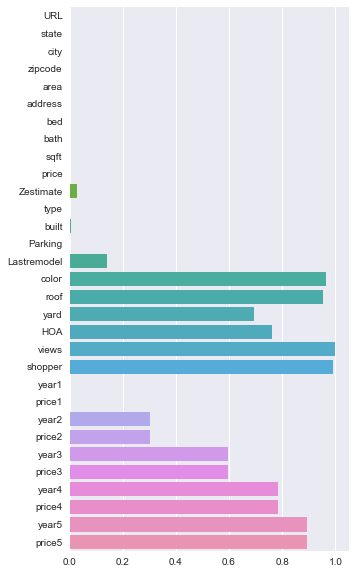

In [6]:
plt.figure(figsize=(5,10))
sns.barplot(y=data.isnull().sum().index, x=data.isnull().sum().values*1.0/data.shape[0])

In [7]:
useful_columns = ["city","zipcode","area","bed","bath","sqft","price","Zestimate","type","built","Parking","Lastremodel","year1","price1","year2","price2","year3","price3","year4","price4","year5","price5"]
data = data.loc[:, useful_columns]
print data.shape
data.head()

(49550, 22)


,city,zipcode,area,bed,bath,sqft,price,Zestimate,type,built,Parking,Lastremodel,year1,price1,year2,price2,year3,price3,year4,price4,year5,price5
0,Fremont,94555,Northgate,4,1,1400,140000.0,986436,Single Family,1970,Garage - Attached,1970.0,06/01/99,292000,38400,140000,NaN,NaN,NaN,NaN,NaN,NaN
1,Fremont,94538,Downtown,2,2,1042,160000.0,535006,Condo,1972,No Data,1972.0,37570,225000,04/28/17,160000,NaN,NaN,NaN,NaN,NaN,NaN
2,Fremont,94539,Mission Valley,3,2,1434,130000.0,1.32095e+06,Single Family,1961,Garage - Attached,1962.0,04/25/17,130000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fremont,94538,Sundale,3,1,948,141500.0,668271,Single Family,1959,Garage - Attached,1961.0,06/26/00,329000,04/21/17,141500,NaN,NaN,NaN,NaN,NaN,NaN
4,Fremont,94538,Blacow,2,2.5,1157,60000.0,710981,Condo,1994,1 space,1994.0,02/17/95,173000,02/29/00,244500,07/21/15,605000,03/31/17,60000,NaN,NaN


### city

In [8]:
count = Counter(data.city)
usefulValues = np.array(count.keys())[np.array(count.values()) > 1000]
data.city = np.array([x if x in usefulValues else np.nan for x in data.city])
nanCounterMostCommon(data.city)

[('San Jose', 26850),
 ('Fremont', 6317),
 ('Sunnyvale', 3312),
 ('Santa Clara', 2987),
 ('San Mateo', 2916),
 ('Redwood City', 2027),
 ('Mountain View', 1964),
 ('Union City', 1754),
 ('Newark', 1398),
 ('nan', 25)]

### zipcode

In [9]:
data.zipcode = convertInt(data.zipcode)
count = Counter(data.zipcode)
usefulValues = np.array(count.keys())[np.array(count.values()) > 100]   
data.zipcode = [x if x in usefulValues else np.nan for x in data.zipcode]
nanCounterMostCommon(data.zipcode)

[(95123.0, 2511),
 (95125.0, 2150),
 (94536.0, 2129),
 (94587.0, 1746),
 (95124.0, 1634),
 (94538.0, 1615),
 (95051.0, 1466),
 (94539.0, 1442),
 (94560.0, 1398),
 (95136.0, 1382),
 (95112.0, 1281),
 (94087.0, 1267),
 (95111.0, 1189),
 (95120.0, 1153),
 (94555.0, 1130),
 (95126.0, 1108),
 (94403.0, 1090),
 (95118.0, 1083),
 (95131.0, 1032),
 (94401.0, 1006),
 (95132.0, 1004),
 (94086.0, 974),
 (95116.0, 953),
 (95135.0, 927),
 (95148.0, 926),
 (94043.0, 923),
 (95050.0, 920),
 (95122.0, 878),
 (95128.0, 878),
 (94061.0, 855),
 (95127.0, 823),
 (95129.0, 807),
 (95121.0, 806),
 (95133.0, 747),
 (95138.0, 746),
 (95110.0, 736),
 (94040.0, 698),
 (94402.0, 633),
 (95054.0, 607),
 (95117.0, 580),
 (94085.0, 571),
 (94089.0, 518),
 (94065.0, 458),
 (94062.0, 423),
 (95119.0, 363),
 (94041.0, 335),
 (95130.0, 310),
 (95139.0, 273),
 (94063.0, 250),
 (95134.0, 197),
 (94404.0, 181),
 (95113.0, 127)]

### area

In [10]:
count = Counter(data.area)
usefulValues = np.array(count.keys())[np.array(count.values()) > 10] 
data.area = [x if x in usefulValues else np.nan for x in data.area]
nanCounterMostCommon(data.area)

/Users/qiweili/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  app.launch_new_instance()


[('Willow Glen', 3304),
 ('Evergreen', 2511),
 ('Downtown', 2500),
 ('Blossom Valley', 2281),
 ('West San Jose', 2127),
 ('East San Jose', 2007),
 ('Santa Teresa', 1986),
 ('North Valley', 1846),
 ('Cambrian Park', 1805),
 ('94587', 1745),
 ('Almaden Valley', 1577),
 ('Fairgrounds', 1510),
 ('95051', 1464),
 ('94560', 1397),
 ('Berryessa', 1045),
 ('95050', 913),
 ('Alum Rock-East Foothills', 744),
 ('Edenvale - Seven Trees', 724),
 ('North San Jose', 621),
 ('95054', 607),
 ('Ponderosa', 533),
 ('Lakewood', 524),
 ('Ardenwood', 511),
 ('Northgate', 471),
 ('Centerville', 466),
 ('Rose Garden', 458),
 ('De Anza', 445),
 ('94043', 436),
 ('Cherry-Guardino', 420),
 ('West Murphy', 409),
 ('Warm Springs', 371),
 ('94040', 358),
 ('Glenmoor', 355),
 ('Ortega', 326),
 ('Cabrillo', 325),
 ('Washington', 321),
 ('East Murphy', 320),
 ('Serra', 299),
 ('Central', 293),
 ('Irvington', 288),
 ('Niles', 265),
 ('Grimmer', 252),
 ('North Central', 237),
 ('Sundale', 221),
 ('Mission Valley', 219),

### bed

In [11]:
data.bed = convertInt(data.bed)
count = Counter(data.bed)
usefulValues = np.array(count.keys())[np.array(count.values()) > 100] 
data.bed = [x if x in usefulValues else np.nan for x in data.bed]
nanCounterMostCommon(data.bed)

[(3.0, 19677),
 (4.0, 12343),
 (2.0, 10798),
 (5.0, 2731),
 (1.0, 2199),
 (6.0, 390)]

### bath 

In [12]:
data.bath = convertFloat(data.bath)
data.bath[(data.bath > 2) & (data.bath < 2.5)] = 2.0
count = Counter(data.bath)
usefulValues = np.array(count.keys())[np.array(count.values()) > 100] 
data.bath = [x if x in usefulValues else np.nan for x in data.bath]
nanCounterMostCommon(data.bath)

/Users/qiweili/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


[(2.0, 21892),
 (3.0, 8882),
 (1.0, 7532),
 (2.5, 5374),
 (1.5, 1509),
 (4.0, 1439),
 (3.5, 947),
 (5.0, 280),
 (4.5, 168)]

### sqft 

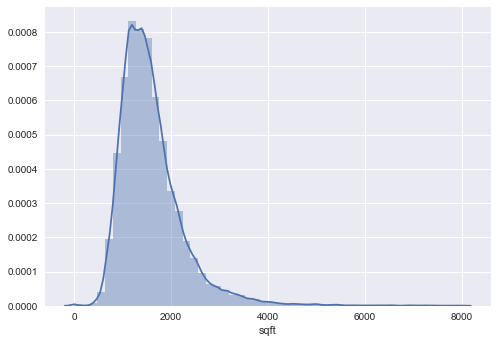

In [13]:
data.sqft = convertFloat(data.sqft, valueConstraint=[0, 8000])
nanDistPlot(data.sqft)

### price

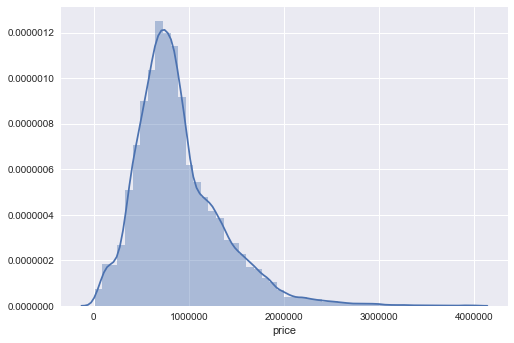

In [14]:
data.price = convertFloat(data.price, valueConstraint=PRICE_CONST)
nanDistPlot(data.price)

### Zestimate 

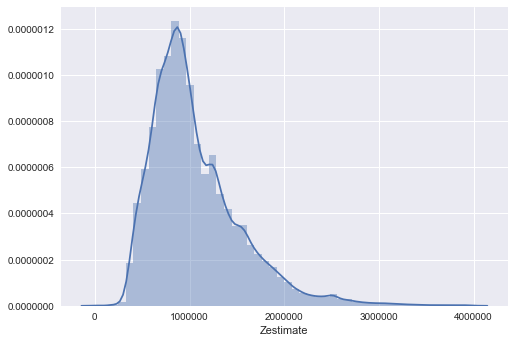

In [15]:
data.Zestimate = convertFloat(onlyNumber(data.Zestimate), valueConstraint=PRICE_CONST)
nanDistPlot(data.Zestimate)

### type 

In [16]:
count = Counter(data.type)
usefulValues = np.array(count.keys())[np.array(count.values()) > 300]
data.type = np.array([x if x in usefulValues else np.nan for x in data.type])
nanCounterMostCommon(data.type)

/Users/qiweili/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  app.launch_new_instance()


[('Single Family', 32223),
 ('Condo', 10862),
 ('Townhouse', 4327),
 ('Multi Family', 943),
 ('nan', 696),
 ('Mobile / Manufactured', 499)]

### built

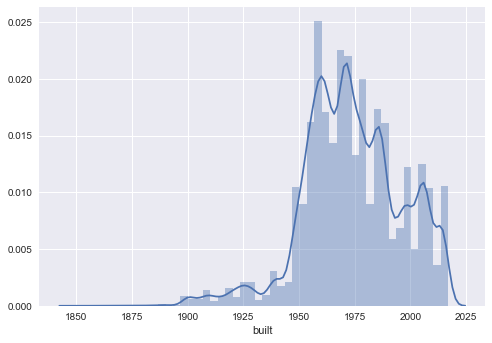

In [17]:
data.built = convertInt(data.built, valueConstraint=[1850, 2018])
nanDistPlot(data.built)

### Parking 

In [18]:
data = data.drop('Parking', axis=1)

### Lastremodel

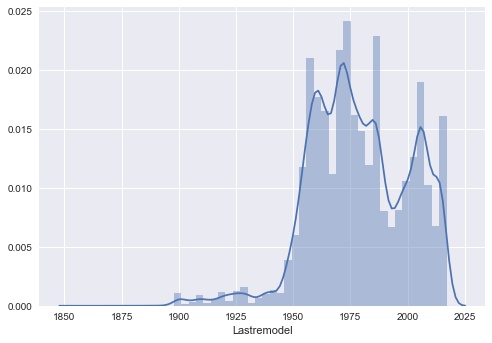

In [19]:
data.Lastremodel = convertInt(data.Lastremodel, valueConstraint=[1850, 2018])
nanDistPlot(data.Lastremodel)

### year1 year2 year3 year4 year5

In [20]:
data.year1 = convertDatetime(data.year1)
data.year2 = convertDatetime(data.year2)
data.year3 = convertDatetime(data.year3)
data.year4 = convertDatetime(data.year4)
data.year5 = convertDatetime(data.year5)

### price1 price2 price3 price4 price5

In [21]:
data.price1 = convertFloat(onlyNumber(data.price1), valueConstraint=PRICE_CONST)
data.price2 = convertFloat(onlyNumber(data.price2), valueConstraint=PRICE_CONST)
data.price3 = convertFloat(onlyNumber(data.price3), valueConstraint=PRICE_CONST)
data.price4 = convertFloat(onlyNumber(data.price4), valueConstraint=PRICE_CONST)
data.price5 = convertFloat(onlyNumber(data.price5), valueConstraint=PRICE_CONST)

### check and save

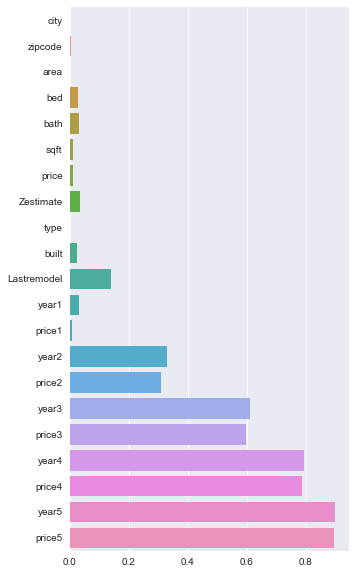

In [22]:
plt.figure(figsize=(5,10))
sns.barplot(y=data.isnull().sum().index, x=data.isnull().sum().values*1.0/data.shape[0])

In [23]:
data.to_csv("./data/clean/cleanData.csv", index=False)

# Archive